## 평가환경 및 장비

In [1]:
import tensorflow as tf
print("HW: ")
!nvidia-smi --query-gpu=name --format=csv,noheader
print("\nOS: ")
!cat /etc/*release | grep "DESCRIPTION"
print("\nDeep learning library : ")
print(tf.__version__)
print("\nMemory : ")
!free -h 

HW: 
NVIDIA GeForce RTX 2080

OS: 
DISTRIB_DESCRIPTION="Ubuntu 20.04.4 LTS"

Deep learning library : 
2.9.1

Memory : 
              total        used        free      shared  buff/cache   available
Mem:           62Gi       8.8Gi        39Gi        29Mi        14Gi        53Gi
Swap:         2.0Gi          0B       2.0Gi


## 데이터 불러오기

In [2]:
import random 
import numpy as np
import pandas as pd
import os 
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GroupKFold 
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve
pd.set_option('display.float_format', lambda x: '%.3f' % x)

files = [ '../data/mimic/all/bfill_6h_drop/worst.h5',
          '../data/ku-icu/dropref/ku_rICU_worst.h5' ,
          '../data/ku-covid/dropref/ku_covid_worst.h5']

D = []
for i, file in enumerate(files):
    print(file)
    temp = {}
    temp['X'] = pd.read_hdf(file,'vitals_labs').reset_index()
    temp['Y'] = pd.read_hdf(file,'interventions').reset_index()
    temp['info'] = pd.read_hdf(file,'patients').reset_index()
    D.append(temp)

../data/mimic/all/bfill_6h_drop/worst.h5
../data/ku-icu/dropref/ku_rICU_worst.h5
../data/ku-covid/dropref/ku_covid_worst.h5


## 환자 지표로부터 규칙기반 지표(MEWS) 계산

In [3]:
def mews_sbp(data):
    if data < 70:       score = 3
    elif data < 80:     score = 2
    elif data < 100:    score = 1
    elif data < 199:    score = 0
    else:               score = 2
    return score

def mews_hr(data):
    if data < 40:       score = 2
    elif data < 50:     score = 1
    elif data < 100:    score = 0
    elif data < 110:    score = 1
    elif data < 129:    score = 2
    else:               score = 3
    return score

def mews_rr(data):
    if data < 9:        score = 2
    elif data < 14:     score = 0
    elif data < 20:     score = 1
    elif data < 29:     score = 2
    else:               score = 3
    return score

def mews_temp(data):
    if data < 35:       score = 2
    elif data < 38.4:   score = 0
    else:               score = 2
    return score

def add_MEWS(df):   
    sbp_score = df['sbp'].apply(mews_sbp)
    hr_score = df['hr'].apply(mews_hr)
    rr_score = df['rr'].apply(mews_rr)
    temp_score = df['temp'].apply(mews_temp)
    df['mews'] = sbp_score+hr_score+rr_score+temp_score
    return df

def add_rox_index(df):   
    rr = np.maximum(1,df['rr'])
    fio2 = np.maximum(0.21,df['fio2'])
    df['rox'] = (df.spo2 / fio2) / rr
    return df

In [4]:
# add news2
def news_rr(data):
    if data <= 8:        score = 3
    elif data <= 11:     score = 1
    elif data <= 20:     score = 0
    elif data <= 24:     score = 2
    else:               score = 3
    return score

def news_spo2(data):
    if data <= 91:        score = 3
    elif data <= 93:     score = 2
    elif data <= 95:     score = 1
    else:               score = 0
    return score

def news_fio2(data):
    if data <= 25:        score = 0
    else:               score = 2
    return score

def news_sbp(data):
    if data <= 90:        score = 3
    elif data <= 100:     score = 2
    elif data <= 110:     score = 1
    elif data <= 219:     score = 0
    else:               score = 3
    return score

def news_hr(data):
    if data <= 40:       score = 3
    elif data <= 50:     score = 1
    elif data <= 90:    score = 0
    elif data <= 110:    score = 1
    elif data <= 130:    score = 2
    else:               score = 3
    return score

def news_temp(data):
    if data <= 35:       score = 3
    elif data <= 36:   score = 1
    elif data <= 38:   score = 0
    elif data <= 39:   score = 1
    else:               score = 2
    return score

def add_NEWS(df):   
    rr_score = df['rr'].apply(news_rr)
    spo2_score = df['spo2'].apply(news_spo2)
    fio2_score = df['fio2'].apply(news_fio2)
    sbp_score = df['sbp'].apply(news_sbp)
    hr_score = df['hr'].apply(news_hr)
    temp_score = df['temp'].apply(news_temp)

    df['news'] = rr_score+spo2_score+fio2_score+sbp_score+hr_score+temp_score
    return df


In [5]:
#sofa, qsofa

def sofa_map(data):
    if data >= 70:        score = 0
    else:               score = 1
    return score

def sofa_pfratio(data):
    if data >= 400:        score = 0
    elif data >=300:   score = 1
    elif data >=200:   score = 2
    elif data >=100:   score = 3
    else:               score = 4
    return score

def sofa_platelets(data):
    if data >= 150:        score = 0
    elif data >=100:   score = 1
    elif data >=50:   score = 2
    elif data >=20:   score = 3
    else:               score = 4
    return score

def add_SOFA(df):   
    map_score = ((df['sbp'] + df['dbp'])/2).apply(sofa_map)
    pfratio_score = df['pfratio'].apply(sofa_pfratio)
    platelets_score = df['platelets'].apply(sofa_platelets)

    df['sofa'] = map_score+pfratio_score+platelets_score
    return df



def qsofa_sbp(data):
    if data <= 100:        score = 1
    else:               score = 0
    return score

def qsofa_rr(data):
    if data >= 22:        score = 1
    else:               score = 0
    return score

def add_qSOFA(df):   
    sbp_score = df['pfratio'].apply(qsofa_sbp)
    rr_score = df['platelets'].apply(qsofa_rr)

    df['qsofa'] = sbp_score + rr_score
    return df



In [6]:
for idx in range(len(files)):
    add_rox_index(D[idx]['X'])
    add_MEWS(D[idx]['X'])
    add_NEWS(D[idx]['X'])
    add_SOFA(D[idx]['X'])
    add_qSOFA(D[idx]['X'])

## 데이터 정규화

In [7]:
from sklearn.preprocessing import StandardScaler
vital = ['rr','hr','spo2','sbp','dbp','temp']
CBC = ['hct','hb','platelets','wbc','rbc','mch','mchc','mcv']
ABGA = ['ph','hco3', 'po2','pco2','sao2','fio2','pfratio']
COLS = vital+CBC+ABGA

std_scaler = StandardScaler()
fitted = std_scaler.fit(D[0]['X'][COLS+['age']])

D[0]['X'][COLS+['age']] = std_scaler.transform(D[0]['X'][COLS+['age']])
D[1]['X'][COLS+['age']] = std_scaler.transform(D[1]['X'][COLS+['age']])
D[2]['X'][COLS+['age']] = std_scaler.transform(D[2]['X'][COLS+['age']])

In [8]:
#extract index
from sklearn.model_selection import train_test_split
RANDOM = 0
train_ids, valid_ids = train_test_split(D[0]['info'].reset_index(drop=True), test_size=0.2, 
                                    random_state=RANDOM, stratify=D[0]['info']['MV_ICU'])

key = pd.Series(D[0]['X'].reset_index()['subject_id'].unique())
valid_indices = np.where(key.isin(valid_ids['subject_id']))[0]


## BiLSTM 모델 학습/평가를 위해 데이터 tensor 형태로 변경

In [9]:
RANDOM = 0
MAX_LEN = 240
PREDICTION_WINDOW = 12
GRAY_AREA = 3

def create_x_matrix(x):
    zeros = np.zeros((MAX_LEN, x.shape[1]-4))
    x = x.values
    x = x[:(MAX_LEN), 4:]
    zeros[0:x.shape[0], :] = x
    return zeros

def create_y_matrix(y):
    zeros = np.zeros((MAX_LEN+PREDICTION_WINDOW+GRAY_AREA, y.shape[1]-4))
    y = y.values
    y = y[:,4:]
    y = y[:MAX_LEN+PREDICTION_WINDOW+GRAY_AREA, :]
    zeros[:y.shape[0], :] = y
    return zeros

cols_without_CBC = ['subject_id', 'hadm_id', 'icustay_id', 'hours_in', 'absolute_time',
       'rr', 'hr', 'spo2', 'sbp', 'dbp', 'temp', 'ph', 'hco3', 'po2', 'pco2', 'sao2',
       'fio2', 'pfratio', 'age', 'gender_F', 'gender_M', 'rox', 'mews']

T = [] # tensorized data
for i in range(3):
    temp = {}
    temp['X'] = np.array(list(D[i]['X'].groupby('subject_id').apply(create_x_matrix)))
    temp['Y'] = np.array(list(D[i]['Y'].groupby('subject_id').apply(create_y_matrix)))[:,:,0]
    temp['lengths'] = np.array(list(D[i]['X'].groupby('subject_id').apply(lambda x: x.shape[0])))
    T.append(temp)


valid = {'X' : T[0]['X'][valid_indices],  'Y' : T[0]['Y'][valid_indices], 'lengths' : T[0]['lengths'][valid_indices]}

T.append(valid)

In [10]:
SLICE_SIZE = 6
GRAY = True
LIMIT_TIMESTEP = True

def tensorize(X_tensor, Y_tensor, lengths, gray=False, limit=False):
    num_patients = X_tensor.shape[0]
    timesteps = X_tensor.shape[1]
    num_features = X_tensor.shape[2]
    
    X_tensor_new = np.zeros((lengths.sum(), SLICE_SIZE, num_features))
    Y_tensor_new = np.zeros((lengths.sum()))
    
    MAX_ROWS_PER_PATIENTS = 72
    
    gray_cnt = 0
    limit_cnt = 0
    current_row = 0
    for patient_index in range(num_patients):
        x_patient = X_tensor[patient_index]
        y_patient = Y_tensor[patient_index]
        length = lengths[patient_index]

        if((limit==True) & (length - SLICE_SIZE > MAX_ROWS_PER_PATIENTS)):
            timesteps = sorted(random.sample(range(length - SLICE_SIZE),MAX_ROWS_PER_PATIENTS))
            limit_cnt += (length - SLICE_SIZE) - MAX_ROWS_PER_PATIENTS
        else:
            timesteps = range(length - SLICE_SIZE)

        
        for timestep in timesteps:
            result = None
            x_window = x_patient[timestep:timestep+SLICE_SIZE]
            y_window = y_patient[timestep:timestep+SLICE_SIZE]
            result_window = y_patient[timestep+SLICE_SIZE:timestep+SLICE_SIZE+PREDICTION_WINDOW]
            gray_window = y_patient[timestep+SLICE_SIZE+PREDICTION_WINDOW:timestep+SLICE_SIZE+PREDICTION_WINDOW+GRAY_AREA]
            
            if (max(result_window, default=0)==1):
                result = 1
            elif (max(result_window, default=0)==0):
                result = 0
                if(gray==True):
                    gray_window = y_patient[timestep+SLICE_SIZE+PREDICTION_WINDOW:timestep+SLICE_SIZE+PREDICTION_WINDOW+GRAY_AREA]
                    if max(gray_window, default=0) == 1:
                        gray_cnt += 1
                        result = None

            if result != None:
                X_tensor_new[current_row] = x_window
                Y_tensor_new[current_row] = result
                current_row += 1

    X_tensor_new = X_tensor_new[:current_row,:,:]
    Y_tensor_new = Y_tensor_new[:current_row]

    return X_tensor_new, Y_tensor_new



X = []
Y = []
for i in range(4):
    print(f"index {i}")
    if i < 1: 
        x, y = tensorize(T[i]['X'],T[i]['Y'],T[i]['lengths'], gray=GRAY, limit=LIMIT_TIMESTEP)
    else:
        x, y = tensorize(T[i]['X'],T[i]['Y'],T[i]['lengths'], gray=False, limit=False)
    print(f"X tensor shape: {x.shape}")
    print(f"Y tensor shape: {y.shape}")
    print(f"Y positive: {y.sum()}")
    print(f"class ratio: {y.sum()/len(y)}")
    X.append(x)
    Y.append(y)


index 0
X tensor shape: (958072, 6, 30)
Y tensor shape: (958072,)
Y positive: 36319.0
class ratio: 0.037908424419041575
index 1
X tensor shape: (114869, 6, 30)
Y tensor shape: (114869,)
Y positive: 1260.0
class ratio: 0.010969016880098199
index 2
X tensor shape: (13710, 6, 30)
Y tensor shape: (13710,)
Y positive: 564.0
class ratio: 0.04113785557986871
index 3
X tensor shape: (254005, 6, 30)
Y tensor shape: (254005,)
Y positive: 11130.0
class ratio: 0.04381803507804964


In [11]:
#Extract MEWS
Rox = []
Mews = []
News = []
SOFA = []
qSOFA = []

for i in range(4):
    Rox.append(X[i][:,-1,-5])
    Mews.append(X[i][:,-1,-4])
    News.append(X[i][:,-1,-3])
    SOFA.append(X[i][:,-1,-2])
    qSOFA.append(X[i][:,-1,-1])
    X[i] = X[i][:,:,:-5]

def extract_max(ls):
    max_val = max(max(ls[1]), max(ls[2]), max(ls[0]))
    print(max_val)
    return max_val

max_ROX = extract_max(Rox)
max_MEWS = extract_max(Mews)
max_NEWS = extract_max(News)
max_SOFA = extract_max(SOFA)
max_qSOFA = extract_max(qSOFA)

rox_prob = []
mews_prob = []
news_prob = []
sofa_prob = []
qsofa_prob = []

for i in range(4):
    rox_prob.append(1 - Rox[i]/max_ROX)
    mews_prob.append(Mews[i]/max_MEWS)
    news_prob.append(News[i]/max_NEWS)
    sofa_prob.append(SOFA[i]/max_SOFA)
    qsofa_prob.append(qSOFA[i]/max_qSOFA)

for i in range(4):
    print(i)
    print(roc_auc_score(Y[i], rox_prob[i], average=None))
    print(roc_auc_score(Y[i], mews_prob[i], average=None))
    print(roc_auc_score(Y[i], news_prob[i], average=None))
    print(roc_auc_score(Y[i], sofa_prob[i], average=None))
    print(roc_auc_score(Y[i], qsofa_prob[i], average=None))


476.1904761904762
11.0
15.0
9.0
2.0
0
0.7082807797326899
0.5851058722950043
0.5958958818578404
0.6851370847305662
0.5514699543048194
1
0.7412231236710372
0.6803374061997938
0.7115571200973765
0.6912876655619309
0.5248834208166215
2
0.8126020319531977
0.5694351381592222
0.5749874837207446
0.8098223524562659
0.6639026999556534
3
0.6715854766505792
0.5879519071618393
0.6092167457165331
0.7018915477450558
0.5305835862050469


## BiLSTM 모델 학습/평가 수행코드

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import LSTM, Bidirectional, Concatenate, GRU
from tensorflow.keras.layers import Input, Dense, Dropout, GaussianNoise
from tensorflow.keras.layers import BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import metrics, regularizers
from sklearn.metrics import average_precision_score, accuracy_score
from sklearn.utils import class_weight
from tqdm import tqdm
from sklearn.model_selection import KFold

MODE = 'test'

seed =42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

class_weights = class_weight.compute_class_weight(class_weight ='balanced', classes=np.unique(y), y =y)
print("MODE: ", MODE)
if MODE == 'train':
    print(class_weights)
    x = X[0]
    y = Y[0]
    y_valid=[]
    lstm_preds=[]

    with tf.device("/device:GPU:0"):
        dp = 0.4
        hd = 8
        reg = 0.01
        x_input = Input(shape=(x.shape[-2:])) # (6, 25)
        d0 = Dropout(dp)(x_input)
        x1 = Bidirectional(LSTM(units=hd, return_sequences=True))(d0)
        d1 = Dropout(dp)(x1)
        l1 = Bidirectional(LSTM(units=hd, return_sequences=True))(d1)
        d2 = Dropout(dp)(l1)
        l2 = Bidirectional(LSTM(units=hd, return_sequences=False))(d2)
        d3 = Dropout(dp)(l2)
        output = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(reg))(d3)

        lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4,  patience=3, verbose=True)
        es = EarlyStopping(monitor='val_loss', mode='min', patience=3, 
                            restore_best_weights=True, verbose=True)
        
        skf = KFold(n_splits=5, shuffle=True)
        i = 0
        fold_pred = []
        fold_true = []
        icu_pred = []
        icu_true = []
        covid_pred = []
        covid_true = []
        eval = []
        for train, validation in skf.split(x, y):
            checkpoint_filepath = f"./logs/kf{i}.h5"
            sv = tf.keras.callbacks.ModelCheckpoint(
                checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
                save_weights_only=False, mode='auto', save_freq='epoch',
                options=None
            )
            model = Model(inputs=x_input, outputs=output, 
                    name='Bidirectional_LSTM')
            model.compile(
                # optimizer='adam', 
                # loss='binary_crossentropy', 
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.2), 
                metrics=['acc',metrics.AUC(name = 'auc')])
            model.fit(
            x[train], y[train],
                    validation_data=(x[validation], y[validation]), class_weight=dict(enumerate(class_weights)), epochs=20, batch_size=128, 
                    callbacks=[es,lr,sv], verbose=True)
            score = model.evaluate(x[validation], y[validation], batch_size=128)
            print(f"score: {score}")
            eval.append(score)
            fold_pred.append(model.predict(x[validation]).squeeze())
            fold_true.append(y[validation])
            icu_pred.append(model.predict(X[1]).squeeze())
            icu_true.append(Y[1])
            covid_pred.append(model.predict(X[2]).squeeze())
            covid_true.append(Y[2])

            i += 1

if MODE == 'test':
    best_model = load_model('../model/best/lstm_dp04.h5')
    best_model.summary()

MODE:  test
Model: "Bidirectional_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 6, 25)]           0         
                                                                 
 dropout_20 (Dropout)        (None, 6, 25)             0         
                                                                 
 bidirectional_15 (Bidirecti  (None, 6, 16)            2176      
 onal)                                                           
                                                                 
 dropout_21 (Dropout)        (None, 6, 16)             0         
                                                                 
 bidirectional_16 (Bidirecti  (None, 6, 16)            1600      
 onal)                                                           
                                                                 
 dropout_22 (Dropout)        (None, 

## BiLSTM 모델의 예측성능 평가지표

In [13]:
print("Predict severity of patients using BiLSTM Model...")


y_prob=[] # model prediction probability
for i in range(4):
    y_prob.append(best_model.predict(X[i]).squeeze())    

acc_bilstm = accuracy_score(Y[1],np.where(y_prob[1]>0.5,1,0))
print("\nBiLSTM 모델 정확도 (KU-ICU): ", acc_bilstm)
        

Predict severity of patients using BiLSTM Model...


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
for i in range(4):
    print(Y[i].shape)
    print(y_prob[i].shape)
    print(mews_prob[i].shape)

(958038,)
(958038,)
(958038,)
(114869,)
(114869,)
(114869,)
(13710,)
(13710,)
(13710,)
(254005,)
(254005,)
(254005,)


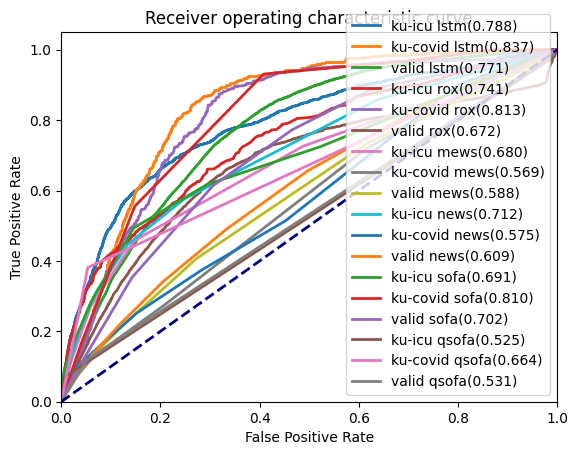

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
# Compute ROC curve and ROC area for each class

fpr_list = []
tpr_list = []
auc_list = []
precision_list = []
recall_list = []
auprc_list = []

all_test = Y[1:4]
all_pred = y_prob[1:4]+ rox_prob[1:4] + mews_prob[1:4] +news_prob[1:4] + sofa_prob[1:4] + qsofa_prob[1:4]

for i in range(3*6):
    fpr, tpr, _ = roc_curve(all_test[i%3], all_pred[i])
    pr, rec, _ = precision_recall_curve(all_test[i%3], all_pred[i])
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(auc(fpr,tpr))
    precision_list.append(pr)
    recall_list.append(rec)
    auprc_list.append(auc(rec,pr))
plt.figure()
lw = 2
label = ['ku-icu','ku-covid', 'valid']
label2 = ['lstm','rox', 'mews','news','sofa','qsofa']




for i in range(3*6):
    plt.plot(
        fpr_list[i],
        tpr_list[i],
        lw=lw,
        label=label[i%3] + " "+ label2[i//3] + "(%0.3f)" % auc_list[i]
    )
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic curve")
plt.legend(loc="lower right")
plt.show()

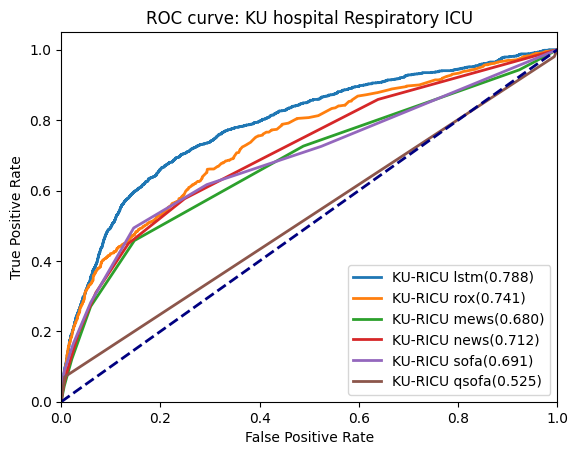

In [ ]:
plt.figure()
lw = 2
label = ['KU-RICU','KU-COVID','MIMIC-valid',]
label2 = ['lstm','rox', 'mews','news','sofa','qsofa']

#for i in {0,3,6}:
for idx in range(6):
    i = idx*3
    plt.plot(
        fpr_list[i],
        tpr_list[i],
        lw=lw,
        label=label[i%3] + " "+ label2[i//3] + "(%0.3f)" % auc_list[i]
    )
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve: KU hospital Respiratory ICU")
plt.legend(loc="lower right")
plt.show()

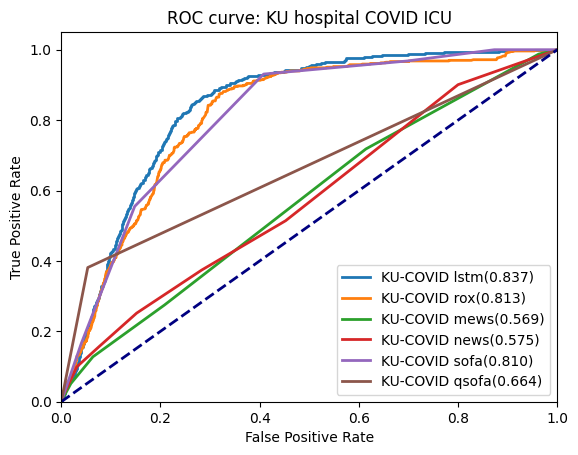

In [ ]:

plt.figure()
lw = 2
label = ['KU-RICU','KU-COVID','MIMIC-valid',]
label2 = ['lstm','rox', 'mews','news','sofa','qsofa']

#for i in {1,4,7}:
for idx in range(6):
    i = idx*3 + 1
    plt.plot(
        fpr_list[i],
        tpr_list[i],
        lw=lw,
        label=label[i%3] + " "+ label2[i//3] + "(%0.3f)" % auc_list[i]
    )
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("ROC curve: KU hospital COVID ICU")
plt.legend(loc="lower right")
plt.show()

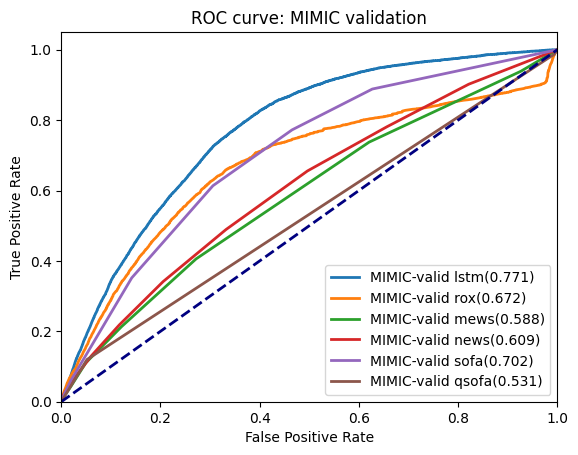

In [ ]:

plt.figure()
lw = 2
label = ['KU-RICU','KU-COVID','MIMIC-valid',]
label2 = ['lstm','rox', 'mews','news','sofa','qsofa']

# for i in {2,5,8}:
for idx in range(6):
    i = idx*3 + 2
    plt.plot(
        fpr_list[i],
        tpr_list[i],
        lw=lw,
        label=label[i%3] + " "+ label2[i//3] + "(%0.3f)" % auc_list[i]
    )
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve: MIMIC validation")
plt.legend(loc="lower right")
plt.show()

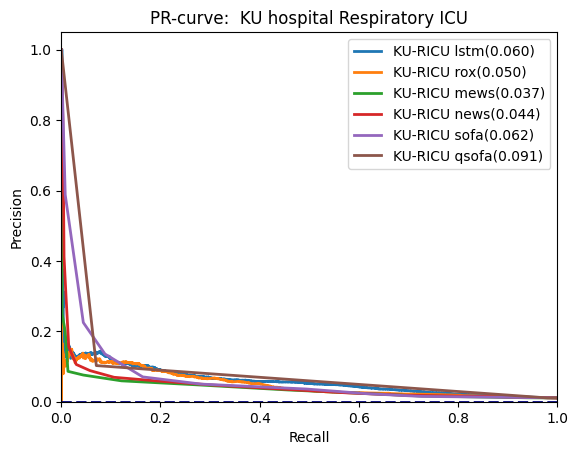

In [ ]:

plt.figure()
lw = 2
label = ['KU-RICU','KU-COVID','MIMIC-valid',]
label2 = ['lstm','rox', 'mews','news','sofa','qsofa']

#for i in {0,3,6}:
for idx in range(6):
    i = idx*3
    plt.plot(
        recall_list[i],
        precision_list[i],
        lw=lw,
        label=label[i%3] + " "+ label2[i//3] + "(%0.3f)" % auprc_list[i]
    )
plt.plot([0, 1], [0, 0], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR-curve:  KU hospital Respiratory ICU")
plt.legend(loc="upper right")
plt.show()

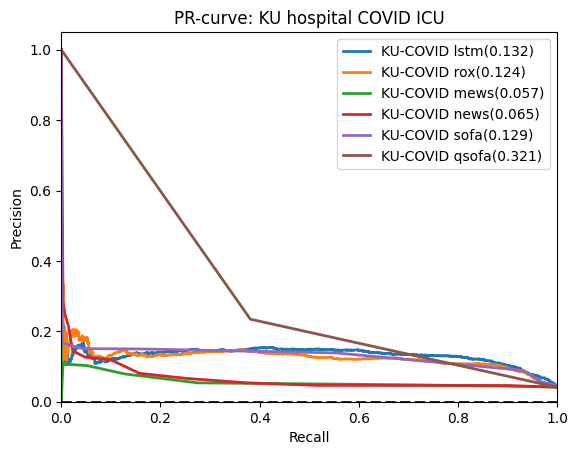

In [ ]:

plt.figure()
lw = 2
label = ['KU-RICU','KU-COVID','MIMIC-valid',]
label2 = ['lstm','rox', 'mews','news','sofa','qsofa']

#for i in {1,4,7}:
for idx in range(6):
    i = idx*3 + 1
    plt.plot(
        recall_list[i],
        precision_list[i],
        lw=lw,
        label=label[i%3] + " "+ label2[i//3] + "(%0.3f)" % auprc_list[i]
    )
plt.plot([0, 1], [0, 0], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR-curve: KU hospital COVID ICU")
plt.legend(loc="upper right")
plt.show()

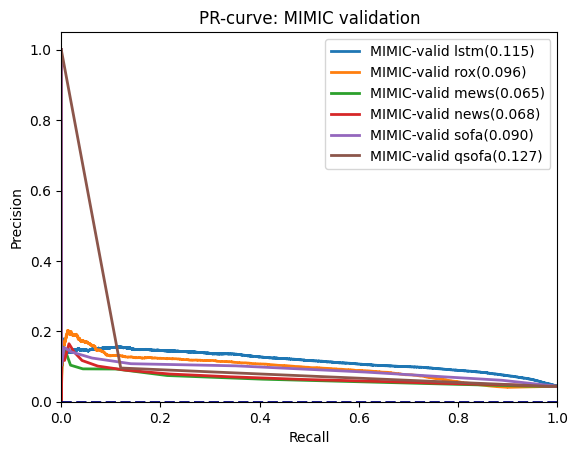

In [ ]:

plt.figure()
lw = 2
label = ['KU-RICU','KU-COVID','MIMIC-valid',]
label2 = ['lstm','rox', 'mews','news','sofa','qsofa']

#for i in {2,5,8}:
for idx in range(6):
    i = idx*3 + 2
    plt.plot(
        recall_list[i],
        precision_list[i],
        lw=lw,
        label=label[i%3] + " "+ label2[i//3] + "(%0.3f)" % auprc_list[i]
    )
plt.plot([0, 1], [0, 0], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR-curve: MIMIC validation")
plt.legend(loc="upper right")
plt.show()

In [ ]:
SDasdf

NameError: name 'SDasdf' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
# Compute ROC curve and ROC area for each class

fpr_list = []
tpr_list = []
auc_list = []
precision_list = []
recall_list = []
auprc_list = []

all_test = Y[1:4] + Y[1:4]
all_pred = y_prob + mews_prob

for i in range(9):
    fpr, tpr, _ = roc_curve(all_test[i], all_pred[i])
    pr, rec, _ = precision_recall_curve(all_test[i], all_pred[i])
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(auc(fpr,tpr))
    precision_list.append(pr)
    recall_list.append(rec)
    auprc_list.append(auc(rec,pr))
plt.figure()
lw = 2
label = ['valid','ku-icu','ku-covid']
label2 = ['lstm','rox','mews']

for i in range(9):
    plt.plot(
        fpr_list[i],
        tpr_list[i],
        lw=lw,
        label=label[i%3] + " "+ label2[i//3] + "(%0.3f)" % auc_list[i]
    )
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic curve")
plt.legend(loc="lower right")
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [114869, 958038]

In [ ]:

template=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), 
                           height=500, width=700))
colors=px.colors.qualitative.Vivid

def plot_roc(y_val, y_prob):
    fpr_list = []
    tpr_list = []
    auc_list = []
    precision_list = []
    recall_list = []
    auprc_list = []

    all_pred = y_prob +  mews_prob
    
    for i in range(6):
        fpr, tpr, _ = roc_curve(y_val[i%3], all_pred[i])
        pr, rec, _ = precision_recall_curve(y_val[i%3], all_pred[i])
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        precision_list.append(pr)
        recall_list.append(rec)
        auc_list.append(auc(fpr,tpr))
        auprc_list.append(auc(rec,pr))

    label = ['mimic-valid','ku-icu']
    label2 = ['BiLSTM','MEWS']

    #fpr[] 0~2 = bilstm, 3~5 = rox
    fig=make_subplots(rows=1, cols=2, subplot_titles = (label))
    for i in range(2):
        fig.append_trace(go.Scatter(x=fpr_list[i], y=tpr_list[i], line=dict(color=colors[1], width=3), 
            hovertemplate = 'True positive rate = %{tpr_list[i]:.3f}, False positive rate = %{fpr_list[i]:.3f}',
            name=f'{label[i]} {label2[0]} AUC {auc_list[i]:.3f}', legendgroup=i), 
            row=1,col=i+1)
        fig.append_trace(go.Scatter(x=fpr_list[i+3], y=tpr_list[i+3], line=dict(color=colors[3], width=3), 
            hovertemplate = 'True positive rate = %{tpr_list[i+6]:.3f}, False positive rate = %{fpr_list[i+6]:.3f}',
            name=f'{label[i]} {label2[1]} AUC {auc_list[i+3]:.3f}', legendgroup=i), 
            row=1,col=i+1)                    
        fig.add_shape(type="line", xref="x", yref="y", x0=0, y0=0, x1=1, y1=1, 
            line=dict(color="Black", width=1, dash="dot"), row=1, col=i+1)  
        fig.update_xaxes(title='False Positive Rate\n')
    fig.update_layout(template=template, 
        hovermode="x", 
        height=400,
        width=800,
        yaxis_title='True Positive Rate (Sensitivity)')
    fig.show()   

plot_roc(y_val=Y, y_prob=y_prob) 

 Computing LSTM feature importance...
0.7810372690124734


100%|██████████| 21/21 [02:42<00:00,  7.74s/it]

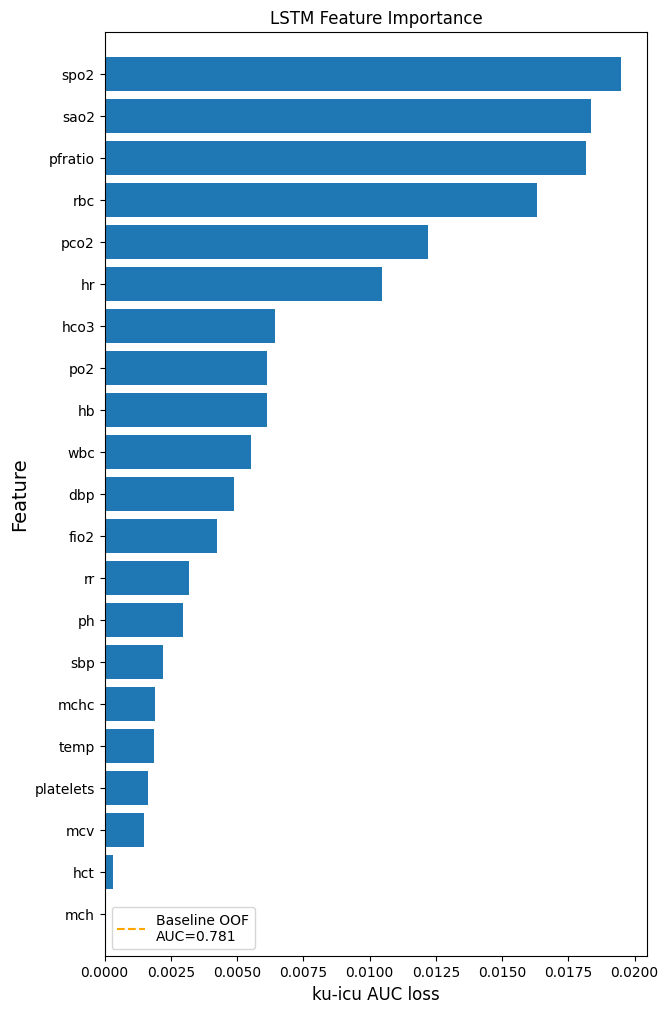

 Computing LSTM feature importance...
0.7736166544201348


100%|██████████| 21/21 [00:19<00:00,  1.06it/s]

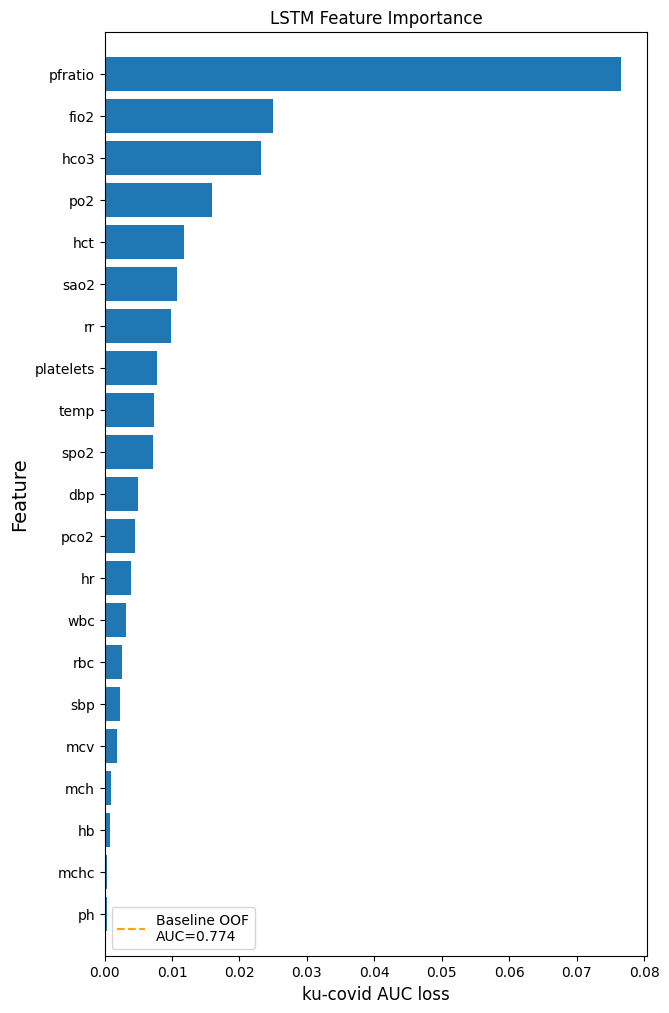

 Computing LSTM feature importance...
0.8445866497977628


100%|██████████| 21/21 [05:56<00:00, 16.99s/it]

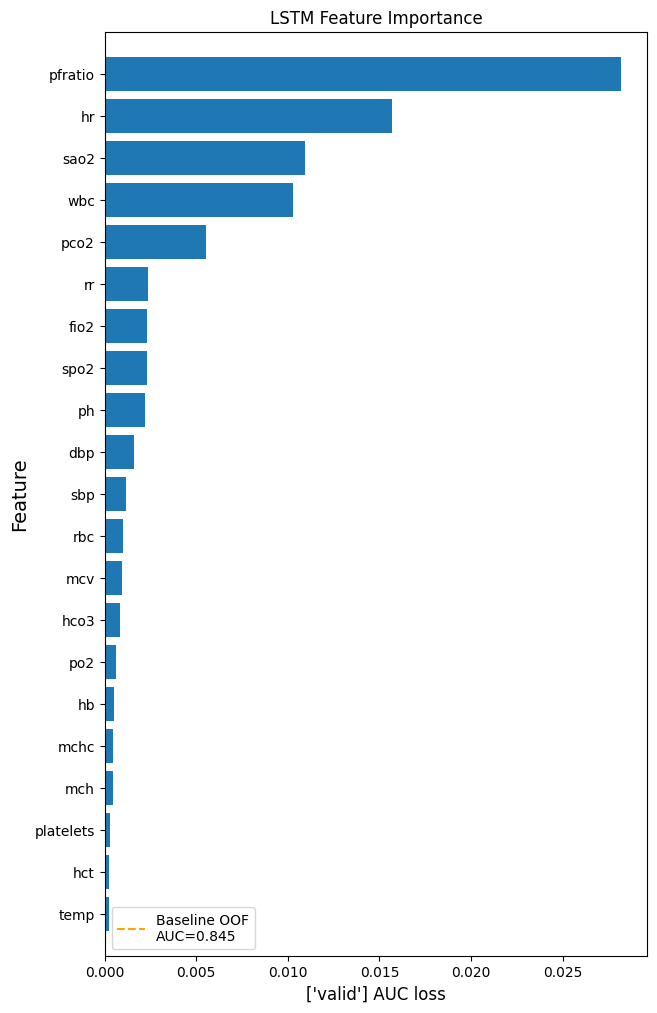

In [ ]:

for i in range(3):
    dataset_name = 'ku-icu','ku-covid',['valid']
    idx = i + 1
    results = []
    print(' Computing LSTM feature importance...')
    
    # COMPUTE BASELINE (NO SHUFFLE)
    oof_preds = model.predict(X[idx], verbose=0).squeeze() 
    #baseline_mae = np.mean(np.abs( oof_preds-Y[idx] ))
    baseline_auc = roc_auc_score(Y[idx],oof_preds)
    print(baseline_auc)
    #results.append({'feature':'BASELINE','auc':baseline_auc})           
    
    for k in tqdm(range(len(COLS))):
        # SHUFFLE FEATURE K
        save_col = X[idx][:,:,k].copy()
        X[idx][:,:,k]=0
        #np.random.shuffle(X[idx][:,:,k])
                
        # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
        oof_preds = model.predict(X[idx], verbose=0).squeeze() 
        auc_diff = abs(roc_auc_score(Y[idx],oof_preds) - baseline_auc)
        results.append({'feature':COLS[k],'auc_diff':auc_diff})
        X[idx][:,:,k] = save_col
    
    # DISPLAY LSTM FEATURE IMPORTANCE
    print()
    df = pd.DataFrame(results)
    df = df.sort_values('auc_diff')
    plt.figure(figsize=(7,12))
    plt.barh(np.arange(len(COLS)),df.auc_diff)
    plt.yticks(np.arange(len(COLS)),df.feature.values)
    plt.title('LSTM Feature Importance',size=12)
    plt.ylim((-1,len(COLS)))
    plt.plot([0,0],[-1,len(COLS)], '--', color='orange',
                label=f'Baseline OOF\nAUC={baseline_auc:.3f}')
    plt.xlabel(f'{dataset_name[i]} AUC loss',size=12)
    plt.ylabel('Feature',size=14)
    plt.legend()
    plt.show()

In [ ]:
asdf